In [1]:
import os
import torch
import mlflow
import gc
import time
from torch.utils.data import DataLoader

from MED.modeling.modeling_utils import train_single_epoch_Sequential, validate_single_epoch_Sequential, retrieve_results_mlflow, retrieve_results_mlflow_sequential, create_summary_df, \
            define_model_objects, load_binary_model_local

from MED.dataset.dataset_utils import compute_window_size_stride, retrieve_dataloaders_window
from MED.dataset.CustomFrameDataset import CustomFrameDataset
from MED.visualization.utils import plot_results_LOSO, plot_cm

In [2]:
#def main(): #Main loop for training.
cuda = False
if cuda:
    torch.cuda.empty_cache() # Clear cache
    
else:
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    torch.mps.empty_cache()

settings = ['LOSO']#, 'LOUO']
tasks = ['All', 'Suturing','Knot_Tying','Needle_Passing']
out1 = ['Bout','Cout','Dout','Eout','Fout','Gout','Hout','Iout']
out2 = ['1out', '2Out', '3out','4out','5out']

exp_kwargs = {
    'error_type': "all_errors",
    'dataset_type': "window", #'window' or 'frame' 
    'save_local': False,
    'pos_weight': False, 
    'use_COG_video': True,
    'out_features': 5, 
    'n_epochs': 15,
    'batch_size': 512,
    'frequency': 5,
    'lr': 1e-3,
    'lr_scheduler': True, 
    'weight_decay': 1e-3,
    'num_layers': 3,
    'hidden_size': 128,
    'model_name': 'SimpleLSTM', #SimpleLSTM, SimpleCNN, Siamese_CNN, Siamese_LSTM 
    'siamese': False,
    'n_comparisons': 20,
    'n_pairs': 20000,
    'video_dims': 32, #32 default
    'loss_or_f1': 'f1',  #'loss' or 'f1' to determine the metric for validation
    'data_type': 'multimodal', #'multimodal' or 'video' or 'kinematics'
    'run_id': "da3920106aec428f86514b9a075e1fe3", #binary run id
    'delete_ND': False,
    'use_true_binary_labels_train': True,
    'compute_from_str': False
}

window_size, stride = compute_window_size_stride(exp_kwargs['frequency'])

best_model = None
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

#Set up folders to save results and images
results_folder = f"results/{exp_kwargs['data_type']}/{exp_kwargs['frequency']}Hz/{exp_kwargs['model_name']}/"
image_folder = f"images/{exp_kwargs['data_type']}/{exp_kwargs['frequency']}Hz/{exp_kwargs['model_name']}/" 

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

if not os.path.exists(image_folder):
    os.makedirs(image_folder)


exp_kwargs_binary = {
    'error_type': 'global',
    'model_name': "SimpleLSTM",
    'dataset_type': "window",
    'save_local': False,
    'return_train_preds': True,
    "compute_from_str": True}

best_model = None
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

#Set up folders to save results and images
results_folder = f"results/{exp_kwargs['data_type']}_ES_sequential/{exp_kwargs['frequency']}Hz/{exp_kwargs['model_name']}/"
image_folder = f"images/{exp_kwargs['data_type']}_ES_sequential/{exp_kwargs['frequency']}Hz/{exp_kwargs['model_name']}/" 

if not os.path.exists(results_folder):
    os.makedirs(results_folder)

if not os.path.exists(image_folder):
    os.makedirs(image_folder)

#Define in_features
in_features_dict = {
    'multimodal': exp_kwargs['video_dims'] + 26,
    'video': exp_kwargs['video_dims'],
    'kinematics': 26
}
exp_kwargs['mstcn_f_dim'] = in_features_dict[exp_kwargs['data_type']] 


#Retrieve binary model results
binary_f1_train, binary_f1_test, binary_acc_train, binary_acc_test, binary_jaccard_train, binary_jaccard_test, binary_cm_train, binary_cm_test, \
train_all_preds, train_all_probs, train_all_labels, train_all_subjects, test_all_preds_binary, test_all_probs_binary,\
test_all_labels_binary, test_all_labels_specific_binary, test_all_gest_labels_binary, test_all_subjects_binary = retrieve_results_mlflow(outs=['1out', '2Out', '3out', '4out', '5out'],
                                                                                                                   setting=settings[0],
                                                                                                                   exp_kwargs=exp_kwargs_binary,   
                                                                                                                    run_id=exp_kwargs['run_id'])


#Retrieve binary models
model_folder = f"models/multimodal/5Hz/SimpleLSTM/"
model_name = "SimpleLSTM"
model_dict, fe_dict = load_binary_model_local(model_folder=model_folder, outs=['1out', '2Out', '3out', '4out', '5out'], model_name=model_name, exp_kwargs=exp_kwargs, device=device)

Loaded binary models from models/multimodal/5Hz/SimpleLSTM/.


Loading data for LOSO with trial 1out...


/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)
/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)


Windowing data...
Creating datasets and dataloaders...
Number of training windows: 3174
Number of testing windows: 1078
Class distribution for LOSO with trial 1out: [2.2041666507720947, 7.2136359214782715, 3.248720407485962, 27.84210205078125, 31.117645263671875, 32.387752532958984]
Class distribution for test set LOSO with trial 1out: [3.4006309509277344, 6.533332824707031, 2.3796908855438232, 22.93616485595703, 71.86662292480469, 13.999999046325684]
Number of parameters to optimize: 1599525


100%|██████████| 7/7 [00:03<00:00,  2.11it/s]


Epoch 1/15, F1: 0.3475, Specific F1: 0.2170, Accuracy: 0.6484, Specific Accuracy: 0.3553, Jaccard: 0.2780, Specific Jaccard: 0.1336, Loss: 1.6974, Time: 3.33 seconds


Test: 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


New best F1 score: 0.08711833785004516 at epoch 1, with weighted F1 score: 0.12082579060309707


Test: 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


New best F1 score: 0.16275461657012164 at epoch 3, with weighted F1 score: 0.27858752265376924


Test: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


New best F1 score: 0.17388406803193335 at epoch 4, with weighted F1 score: 0.37002523004062327


100%|██████████| 7/7 [00:02<00:00,  2.77it/s]


Epoch 6/15, F1: 0.3097, Specific F1: 0.1716, Accuracy: 0.7596, Specific Accuracy: 0.5592, Jaccard: 0.2719, Specific Jaccard: 0.1263, Loss: 1.2179, Time: 2.54 seconds


Test: 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


New best F1 score: 0.17870422535211267 at epoch 8, with weighted F1 score: 0.38734064465846463


100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Epoch 11/15, F1: 0.3158, Specific F1: 0.1789, Accuracy: 0.7621, Specific Accuracy: 0.5638, Jaccard: 0.2761, Specific Jaccard: 0.1313, Loss: 1.1945, Time: 2.74 seconds


100%|██████████| 7/7 [00:02<00:00,  2.77it/s]


Epoch 15/15, F1: 0.3282, Specific F1: 0.1938, Accuracy: 0.7675, Specific Accuracy: 0.5737, Jaccard: 0.2838, Specific Jaccard: 0.1406, Loss: 1.1280, Time: 2.54 seconds


Test: 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Inference rate: 0.3205 ms per frame.


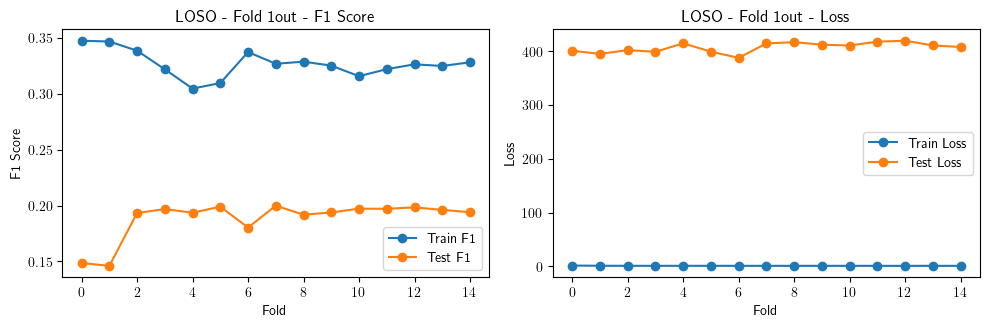

Loading data for LOSO with trial 2Out...


/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)
/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)


Windowing data...
Creating datasets and dataloaders...
Number of training windows: 3476
Number of testing windows: 776
Class distribution for LOSO with trial 2Out: [2.3840878009796143, 6.829076766967773, 3.065255641937256, 27.156246185302734, 38.62221908569336, 23.173330307006836]
Class distribution for test set LOSO with trial 2Out: [2.5953176021575928, 8.083333015441895, 2.621621608734131, 23.51514434814453, 28.74073028564453, 31.039987564086914]
Number of parameters to optimize: 1599525


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


Epoch 1/15, F1: 0.3403, Specific F1: 0.2084, Accuracy: 0.6384, Specific Accuracy: 0.3749, Jaccard: 0.2757, Specific Jaccard: 0.1309, Loss: 1.7291, Time: 3.14 seconds


Test: 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]


New best F1 score: 0.14757789997381515 at epoch 1, with weighted F1 score: 0.29712459821411635


Test: 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]


New best F1 score: 0.2269058110428433 at epoch 4, with weighted F1 score: 0.5029434929817823


100%|██████████| 7/7 [00:02<00:00,  2.54it/s]


Epoch 6/15, F1: 0.3333, Specific F1: 0.1999, Accuracy: 0.7431, Specific Accuracy: 0.5559, Jaccard: 0.2862, Specific Jaccard: 0.1434, Loss: 1.1537, Time: 2.76 seconds


Test: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]


New best F1 score: 0.20350198513692352 at epoch 8, with weighted F1 score: 0.5071755581030619


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch 11/15, F1: 0.3132, Specific F1: 0.1759, Accuracy: 0.7526, Specific Accuracy: 0.5724, Jaccard: 0.2754, Specific Jaccard: 0.1305, Loss: 1.0888, Time: 2.91 seconds


100%|██████████| 7/7 [00:02<00:00,  2.43it/s]


Epoch 15/15, F1: 0.3188, Specific F1: 0.1826, Accuracy: 0.7477, Specific Accuracy: 0.5639, Jaccard: 0.2775, Specific Jaccard: 0.1330, Loss: 1.0906, Time: 2.89 seconds


Test: 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]


Inference rate: 0.1730 ms per frame.


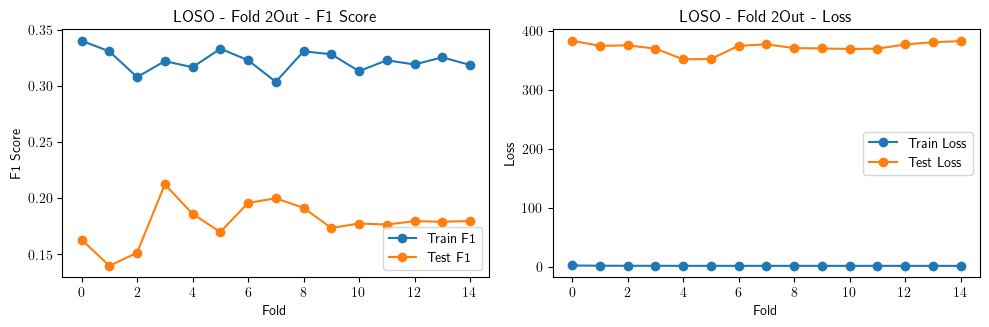

Loading data for LOSO with trial 3out...


/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)
/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)


Windowing data...
Creating datasets and dataloaders...
Number of training windows: 3364
Number of testing windows: 888
Class distribution for LOSO with trial 3out: [2.459064245223999, 6.809716701507568, 2.9176063537597656, 27.129032135009766, 43.68830871582031, 23.361108779907227]
Class distribution for test set LOSO with trial 3out: [2.282776355743408, 7.999999523162842, 3.2057762145996094, 23.99999237060547, 22.199993133544922, 28.645153045654297]
Number of parameters to optimize: 1599525


100%|██████████| 7/7 [00:02<00:00,  2.40it/s]


Epoch 1/15, F1: 0.3152, Specific F1: 0.1782, Accuracy: 0.5654, Specific Accuracy: 0.2661, Jaccard: 0.2531, Specific Jaccard: 0.1038, Loss: 1.9573, Time: 2.93 seconds


Test: 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


New best F1 score: 0.07937743190661478 at epoch 1, with weighted F1 score: 0.09969203533295222


Test: 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


New best F1 score: 0.0906537078950872 at epoch 2, with weighted F1 score: 0.1283173304745457


Test: 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]


New best F1 score: 0.13534932221063606 at epoch 3, with weighted F1 score: 0.23938344147981952


Test: 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]


New best F1 score: 0.19767662399241345 at epoch 4, with weighted F1 score: 0.4150582360859238


Test: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


New best F1 score: 0.20781535800991055 at epoch 5, with weighted F1 score: 0.44161146582449623


100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Epoch 6/15, F1: 0.3133, Specific F1: 0.1760, Accuracy: 0.7521, Specific Accuracy: 0.5813, Jaccard: 0.2759, Specific Jaccard: 0.1310, Loss: 1.1373, Time: 2.78 seconds


Test: 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]


New best F1 score: 0.2089978448275862 at epoch 7, with weighted F1 score: 0.44380209184507274


Test: 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


New best F1 score: 0.21295463308058088 at epoch 8, with weighted F1 score: 0.4479272940343807


Test: 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


New best F1 score: 0.2301778542742398 at epoch 9, with weighted F1 score: 0.477745783404437


100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


Epoch 11/15, F1: 0.3203, Specific F1: 0.1844, Accuracy: 0.7556, Specific Accuracy: 0.5873, Jaccard: 0.2807, Specific Jaccard: 0.1368, Loss: 1.0875, Time: 2.71 seconds


100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


Epoch 15/15, F1: 0.3427, Specific F1: 0.2113, Accuracy: 0.7649, Specific Accuracy: 0.6029, Jaccard: 0.2959, Specific Jaccard: 0.1551, Loss: 1.0563, Time: 2.71 seconds


Test: 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]


Inference rate: 0.1818 ms per frame.


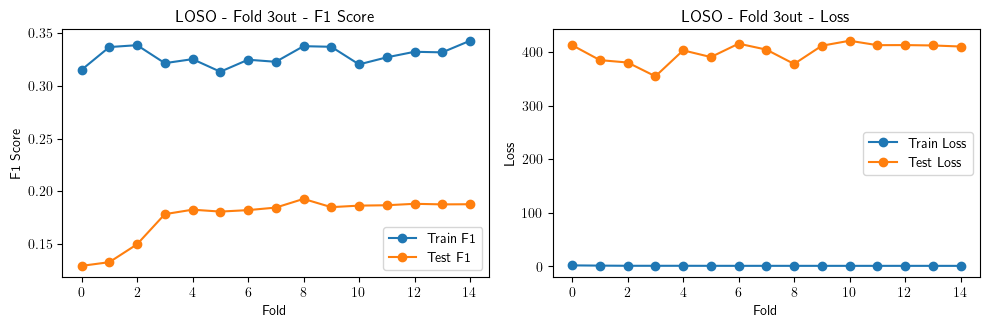

Loading data for LOSO with trial 4out...


/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)
/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)


Windowing data...
Creating datasets and dataloaders...
Number of training windows: 3382
Number of testing windows: 870
Class distribution for LOSO with trial 4out: [2.5314371585845947, 7.449338912963867, 2.823038339614868, 23.650348663330078, 34.51020050048828, 23.16438102722168]
Class distribution for test set LOSO with trial 4out: [2.0665082931518555, 5.761589050292969, 3.749999523162842, 48.333309173583984, 45.789451599121094, 29.999990463256836]
Number of parameters to optimize: 1599525


100%|██████████| 7/7 [00:02<00:00,  2.42it/s]


Epoch 1/15, F1: 0.3312, Specific F1: 0.1974, Accuracy: 0.5985, Specific Accuracy: 0.3340, Jaccard: 0.2670, Specific Jaccard: 0.1204, Loss: 1.7222, Time: 2.91 seconds


Test: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]


New best F1 score: 0.09239766081871345 at epoch 1, with weighted F1 score: 0.11054542674769711


Test: 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]


New best F1 score: 0.11340484145126313 at epoch 2, with weighted F1 score: 0.2163716276812192


Test: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


New best F1 score: 0.179815668202765 at epoch 3, with weighted F1 score: 0.3687690129815367


Test: 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]


New best F1 score: 0.15597071446604394 at epoch 4, with weighted F1 score: 0.41172180392816893


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Epoch 6/15, F1: 0.3285, Specific F1: 0.1942, Accuracy: 0.7395, Specific Accuracy: 0.5679, Jaccard: 0.2839, Specific Jaccard: 0.1406, Loss: 1.1138, Time: 2.75 seconds


Test: 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]


New best F1 score: 0.18166278166278166 at epoch 6, with weighted F1 score: 0.4380710066984576


Test: 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]


New best F1 score: 0.2176221198156682 at epoch 8, with weighted F1 score: 0.4727411824945032


100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


Epoch 11/15, F1: 0.3085, Specific F1: 0.1702, Accuracy: 0.7487, Specific Accuracy: 0.5831, Jaccard: 0.2738, Specific Jaccard: 0.1286, Loss: 1.1269, Time: 2.75 seconds


Test: 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]


New best F1 score: 0.2217626321974148 at epoch 14, with weighted F1 score: 0.47751587905040593


100%|██████████| 7/7 [00:02<00:00,  2.51it/s]


Epoch 15/15, F1: 0.3036, Specific F1: 0.1643, Accuracy: 0.7531, Specific Accuracy: 0.5905, Jaccard: 0.2717, Specific Jaccard: 0.1260, Loss: 1.0769, Time: 2.80 seconds


Test: 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


Inference rate: 0.2171 ms per frame.


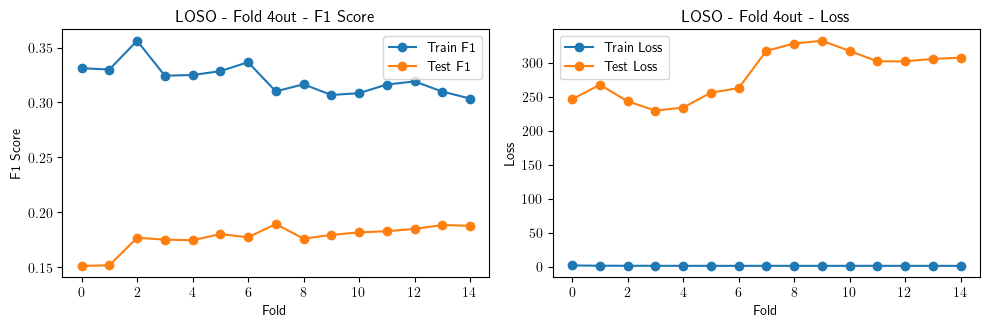

Loading data for LOSO with trial 5out...


/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)
/Users/gonzaloplazaarriola/Desktop/Medtronic/TFM/Multimodal-Error-Detection/MED/dataset/dataset_utils.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_labels_data[frame_index : frame_index + n_frames_in_trial] = torch.tensor(data2['e_labels'].reshape(n_frames_in_trial, 5), dtype=torch.float32)


Windowing data...
Creating datasets and dataloaders...
Number of training windows: 3612
Number of testing windows: 640
Class distribution for LOSO with trial 5out: [2.532959222793579, 6.906309604644775, 2.8712241649627686, 26.755552291870117, 35.76237106323242, 22.296295166015625]
Class distribution for test set LOSO with trial 5out: [1.9335347414016724, 7.804877281188965, 3.7209298610687256, 24.615375518798828, 39.999977111816406, 49.23073196411133]
Number of parameters to optimize: 1599525


100%|██████████| 8/8 [00:03<00:00,  2.48it/s]


Epoch 1/15, F1: 0.3197, Specific F1: 0.1836, Accuracy: 0.5645, Specific Accuracy: 0.2781, Jaccard: 0.2564, Specific Jaccard: 0.1076, Loss: 1.9136, Time: 3.24 seconds


Test: 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


New best F1 score: 0.08687782805429864 at epoch 1, with weighted F1 score: 0.12303507441215703


Test: 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]


New best F1 score: 0.10332765825723574 at epoch 2, with weighted F1 score: 0.16043258215366007


Test: 100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


New best F1 score: 0.13411764705882354 at epoch 3, with weighted F1 score: 0.32113469665322775


Test: 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]


New best F1 score: 0.16935954465011718 at epoch 4, with weighted F1 score: 0.3658950966722709


100%|██████████| 8/8 [00:02<00:00,  2.67it/s]


Epoch 6/15, F1: 0.3023, Specific F1: 0.1627, Accuracy: 0.7467, Specific Accuracy: 0.5801, Jaccard: 0.2701, Specific Jaccard: 0.1242, Loss: 1.1496, Time: 3.00 seconds


100%|██████████| 8/8 [00:02<00:00,  2.69it/s]


Epoch 11/15, F1: 0.3297, Specific F1: 0.1956, Accuracy: 0.7472, Specific Accuracy: 0.5810, Jaccard: 0.2858, Specific Jaccard: 0.1429, Loss: 1.1565, Time: 2.99 seconds


Test: 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


New best F1 score: 0.18177791838025942 at epoch 11, with weighted F1 score: 0.39281854538605443


Test: 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]


New best F1 score: 0.18877302933707923 at epoch 12, with weighted F1 score: 0.40736189268335943


100%|██████████| 8/8 [00:02<00:00,  2.72it/s]


Epoch 15/15, F1: 0.3217, Specific F1: 0.1860, Accuracy: 0.7483, Specific Accuracy: 0.5828, Jaccard: 0.2809, Specific Jaccard: 0.1371, Loss: 1.1224, Time: 2.95 seconds


Test: 100%|██████████| 2/2 [00:00<00:00,  4.02it/s]


Inference rate: 0.1766 ms per frame.


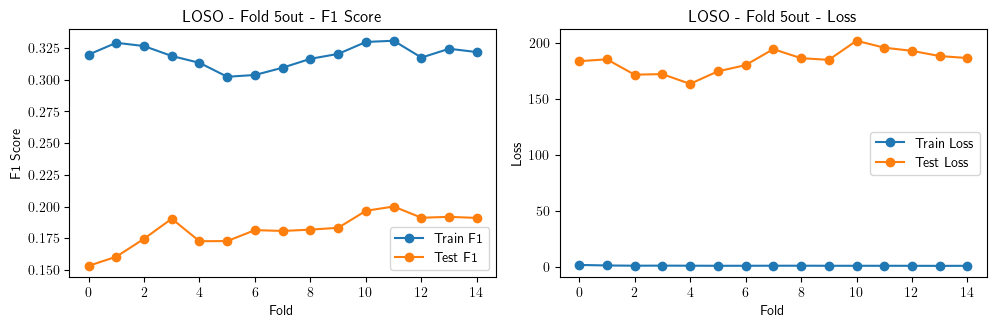

🏃 View run auspicious-sow-742 at: http://127.0.0.1:8080/#/experiments/312202323062431104/runs/4ee8c560f41a400f8a8c9e25b97f3cf6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/312202323062431104


In [3]:
mlflow.set_experiment(f"{exp_kwargs['model_name']}_{exp_kwargs['data_type']}_sequential_ES")

#Ensure seed is set for reproducibility
torch.manual_seed(42)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(42)

samples_train, samples_test, inference_rates, train_times = [], [], [], []
with mlflow.start_run() as run:
    
    #Log the hyperparameters
    if not exp_kwargs['save_local']:
        mlflow.log_params(exp_kwargs)
        run_id = run.info.run_id

    for setting in settings:

        if setting == 'LOSO':
            outs = out2
        else:
            outs = out1

        for out in outs:

            #Delete device and RAM memory
            if cuda:
                torch.cuda.empty_cache()
            else:
                torch.mps.empty_cache()
                
            #Initialize lists to store results for each fold
            train_loss_fold, train_f1_fold, train_f1_fold_specific, train_accuracy_fold, \
                train_accuracy_fold_specific, train_jaccard_fold, train_jaccard_fold_specific, \
                train_cm_fold, train_cm_fold_specific, test_loss_fold, test_f1_fold, test_f1_fold_specific, \
                test_accuracy_fold, test_accuracy_fold_specific, test_jaccard_fold, \
                test_jaccard_fold_specific, test_cm_fold, test_cm_fold_specific, train_times_fold = ([] for _ in range(19))

            best_f1 = 0.0
            best_loss = float('inf')    
            save_best = False

            #a. Load training and testing data
            print(f"Loading data for {setting} with trial {out}...")
            fold_data_path = f"data/LOSO/{exp_kwargs['frequency']}Hz/" + out + '/'
            video_data_path = f"../Chain-of-Gesture/dataset/setting_f1/LOSO/All/{out}"
            #video_data_path = None
            
            #b. Retrieve dataloaders
            train_dataloader, test_dataloader = retrieve_dataloaders_window(fold_data_path=fold_data_path,
                                                                    video_data_path=video_data_path,
                                                                    exp_kwargs=exp_kwargs,
                                                                    window_size=window_size,
                                                                    stride=stride)
            
            samples_train.append(len(train_dataloader.dataset))
            samples_test.append(len(test_dataloader.dataset))
            
            #b.2. Compute class balance
            if not exp_kwargs['siamese']:
                class_counts = train_dataloader.dataset.specific_error_distribution
                class_counts_test = test_dataloader.dataset.specific_error_distribution
                
                #Counter extremely large reverse class frequencies
                #class_counts[0], class_counts[2] = class_counts[0], class_counts[2]
                #class_counts_test[0], class_counts_test[2] = class_counts_test[0], class_counts_test[2]
                #class_counts[1], class_counts[3], class_counts[4], class_counts[5] = class_counts[1]/1.5, class_counts[3]/1.5, class_counts[4]/1.5, class_counts[5]/1.5
                #class_counts_test[1], class_counts_test[3], class_counts_test[4], class_counts_test[5] = class_counts_test[1]/1.5, class_counts_test[3]/1.5, class_counts_test[4]/1.5, class_counts_test[5]/1.5
                
                print(f"Class distribution for {setting} with trial {out}: {class_counts}")
                print(f"Class distribution for test set {setting} with trial {out}: {class_counts_test}") 
            
        
            #c. Define model objects
            feature_extractor, model, criterion, optimizer, scheduler = define_model_objects(exp_kwargs=exp_kwargs,
                                                                                                in_features_dict=in_features_dict,
                                                                                                window_size=window_size,
                                                                                                device=device,
                                                                                                class_counts=[])
            
            binary_model = model_dict[out]
            binary_feature_extractor = fe_dict[out]

            model_folder = f'models/{exp_kwargs["data_type"]}_ES_sequential/{exp_kwargs["frequency"]}Hz/{model.name}/'       

            #d. Training loop
            for epoch in range(exp_kwargs['n_epochs']):
                
                train_start = time.time()
        
                train_average_loss, train_f1_all, train_f1_error_specific, train_f1_error_specific_weighted, train_accuracy_all, train_accuracy_error_specific, \
                train_jaccard_all, train_jaccard_error_specific, train_jaccard_error_specific_weighted, train_cm_all, train_cm_error_specific = train_single_epoch_Sequential(model=model,
                                                            feature_extractor=feature_extractor,
                                                            train_dataloader=train_dataloader,
                                                            criterion=criterion,
                                                            optimizer=optimizer,
                                                            device=device,
                                                            exp_kwargs=exp_kwargs,
                                                            scheduler=scheduler)
                    
                    
                train_end = time.time()
                train_times_fold.append(train_end - train_start)

                if epoch % 5 == 0 or epoch == exp_kwargs['n_epochs'] - 1:
                    print(f"Epoch {epoch + 1}/{exp_kwargs['n_epochs']}, F1: {train_f1_all:.4f}, "
                          f"Specific F1: {train_f1_error_specific:.4f}, "
                          f"Accuracy: {train_accuracy_all:.4f}, "
                          f"Specific Accuracy: {train_accuracy_error_specific:.4f}, "
                          f"Jaccard: {train_jaccard_all:.4f}, "
                          f"Specific Jaccard: {train_jaccard_error_specific:.4f}, "
                          f"Loss: {train_average_loss:.4f}, "
                          f"Time: {train_end - train_start:.2f} seconds")

                #Append to vectors
                train_loss_fold.append(train_average_loss)
                train_f1_fold.append(train_f1_all)
                train_f1_fold_specific.append(train_f1_error_specific)
                train_accuracy_fold.append(train_accuracy_all)
                train_accuracy_fold_specific.append(train_accuracy_error_specific)
                train_jaccard_fold.append(train_jaccard_all)
                train_jaccard_fold_specific.append(train_jaccard_error_specific)
                train_cm_fold.append(train_cm_all.tolist())
                train_cm_fold_specific.append(train_cm_error_specific.tolist())

                #e. Validation loop
                test_average_loss, test_f1_all, test_f1_error_specific, test_f1_error_specific_weighted, test_accuracy_all, test_accuracy_error_specific, \
                test_jaccard_all, test_jaccard_error_specific, test_jaccard_error_specific_weighted, test_cm_all, test_cm_error_specific, \
                inference_rate, test_preds_all, test_preds_error_specific, test_probs_error_specific, \
                test_labels_all, test_labels_error_specific, test_gest_labels, test_subjects = validate_single_epoch_Sequential(model=model,
                                                        binary_model=binary_model,
                                                        binary_feature_extractor=binary_feature_extractor,
                                                        feature_extractor=feature_extractor,
                                                        test_dataloader=test_dataloader,
                                                        device=device,
                                                        exp_kwargs=exp_kwargs)

                #Append to vectors
                test_loss_fold.append(test_average_loss)
                test_f1_fold.append(test_f1_all)
                test_f1_fold_specific.append(test_f1_error_specific)
                test_accuracy_fold.append(test_accuracy_all)
                test_accuracy_fold_specific.append(test_accuracy_error_specific)
                test_jaccard_fold.append(test_jaccard_all)
                test_jaccard_fold_specific.append(test_jaccard_error_specific)
                test_cm_fold.append(test_cm_all.tolist())
                test_cm_fold_specific.append(test_cm_error_specific.tolist())

                if exp_kwargs['loss_or_f1'] == 'loss':
                    if test_average_loss < best_loss:
                        save_best = True
                        best_loss = test_average_loss
                        print(f"New best loss: {test_average_loss} at epoch {epoch + 1}")

                elif exp_kwargs['loss_or_f1'] == 'f1':
                    if test_f1_error_specific_weighted > best_f1:
                        save_best = True
                        best_f1 = test_f1_error_specific_weighted
                        print(f"New best F1 score: {test_f1_error_specific} at epoch {epoch + 1}, with weighted F1 score: {test_f1_error_specific_weighted}")

                if save_best:
                    
                    best_model = {
                        'feature_extractor': feature_extractor,
                        'model': model,
                        'epoch': epoch + 1,
                        'train_loss': train_average_loss,
                        'test_loss': test_average_loss,
                        'train_f1': train_f1_all,
                        'test_f1': test_f1_all, 
                        'train_f1_specific': train_f1_error_specific,
                        'train_f1_specific_weighted': train_f1_error_specific_weighted,
                        'test_f1_specific': test_f1_error_specific,
                        'test_f1_specific_weighted': test_f1_error_specific_weighted,
                        'train_accuracy': train_accuracy_all,
                        'test_accuracy': test_accuracy_all,
                        'train_accuracy_specific': train_accuracy_error_specific,
                        'test_accuracy_specific': test_accuracy_error_specific,
                        'train_jaccard': train_jaccard_all,
                        'test_jaccard': test_jaccard_all,
                        'train_jaccard_specific': train_jaccard_error_specific,
                        'train_jaccard_specific_weighted': train_jaccard_error_specific_weighted,
                        'test_jaccard_specific': test_jaccard_error_specific,
                        'test_jaccard_specific_weighted': test_jaccard_error_specific_weighted,
                        'train_cm': train_cm_all.tolist(),
                        'test_cm': test_cm_all.tolist(),
                        'train_cm_specific': train_cm_error_specific.tolist(),
                        'test_cm_specific': test_cm_error_specific.tolist(),
                        'inference_rate': inference_rate,
                        'test_preds_all': test_preds_all,
                        'test_preds_error_specific': test_preds_error_specific,
                        'test_probs_error_specific': test_probs_error_specific,
                        'test_labels_all': test_labels_all,
                        'test_labels_error_specific': test_labels_error_specific,
                        'test_gest_labels': test_gest_labels,
                        'test_subjects': test_subjects,
                    }

                    save_best = False  #Reset save_best to False after saving the best model
                
                if not exp_kwargs['save_local']:
                    #Log metrics to mlflow
                    mlflow.log_metric(f'train_loss_fold_{out}', train_average_loss, step=epoch)
                    mlflow.log_metric(f'test_loss_fold_{out}', test_average_loss, step=epoch)
                    mlflow.log_metric(f'train_f1_fold_{out}', train_f1_all, step=epoch)
                    mlflow.log_metric(f'test_f1_fold_{out}', test_f1_all, step=epoch)
                    mlflow.log_metric(f'train_acc_fold_{out}', train_accuracy_all, step=epoch)
                    mlflow.log_metric(f'test_acc_fold_{out}', test_accuracy_all, step=epoch)
                    mlflow.log_metric(f'train_jaccard_fold_{out}', train_jaccard_all, step=epoch)
                    mlflow.log_metric(f'test_jaccard_fold_{out}', test_jaccard_all, step=epoch)

            #Display results for fold
            print(f"Inference rate: {inference_rate:.4f} ms per frame.")
            plot_results_LOSO(train_f1_fold=train_f1_fold,
                            test_f1_fold=test_f1_fold,
                            train_loss_fold=train_loss_fold,
                            test_loss_fold=test_loss_fold,
                            setting=setting, out=out,
                            image_folder=image_folder)
            
        
            #Save best model
            if exp_kwargs['save_local']:
                pass   
                        
            else:
                #Log model to mlflow
                #if exp_kwargs['data_type'] != 'kinematics':
                    
                    #mlflow.pytorch.log_model(pytorch_model=best_model['feature_extractor'], 
                        #                    name=f'feature_extractor_{setting}_{out}')
                                
                #mlflow.pytorch.log_model(pytorch_model=best_model['model'], 
                      #                  name=f'model_{setting}_{out}')        
                      # 

                #Save model locally because mlflow gives errors
                if exp_kwargs['data_type'] != 'kinematics':
                    best_model['feature_extractor'] = best_model['feature_extractor'].state_dict()  
                    best_model['model'] = best_model['model'].state_dict()

                else:
                    best_model['feature_extractor'] = None
                    best_model['model'] = best_model['model'].state_dict()
                
                if not os.path.exists(model_folder):    
                    os.makedirs(model_folder)

                #model_path = os.path.join(model_folder, f'best_model_{setting}_{out}.pt')   
                #save_model(best_model=best_model, model_path=model_path)    

                #Log best_model rest of the dictionary without the state dicts
                best_model_dict = best_model.copy()
                best_model_dict.pop('feature_extractor', None)
                best_model_dict.pop('model', None)
                mlflow.log_dict(best_model_dict, f'best_model_{setting}_{out}.json')

            #Compute mean inference rate and train time; append to lists
            samples_test.append(len(test_preds_all))
            inference_rates.append(inference_rate)
            train_times.append(sum(train_times_fold) / len(train_times_fold))

            #Delete memory and variables
            del train_dataloader, test_dataloader, feature_extractor, model, best_model
            gc.collect()

mlflow.end_run()

### Compute metrics

Error Specific Summary DataFrame:


,F1,Accuracy,Jaccard,Train Time,Inference Rate
Train,0.186 ± 0.015,0.577 ± 0.008,0.137 ± 0.009,1.00 ± 0.00,NaN
Test,0.204 ± 0.020,0.546 ± 0.047,0.146 ± 0.017,NaN,0.00 ± 0.00


Error Specific Summary DataFrame:


,F1,Accuracy,Jaccard,Train Time,Inference Rate
Train,0.322 ± 0.013,0.752 ± 0.007,0.281 ± 0.007,1.00 ± 0.00,NaN
Test,0.196 ± 0.005,0.455 ± 0.036,0.129 ± 0.004,NaN,0.00 ± 0.00


Confusion Matrix for Train:
Confusion Matrix for Train:


<Figure size 2250x2250 with 0 Axes>

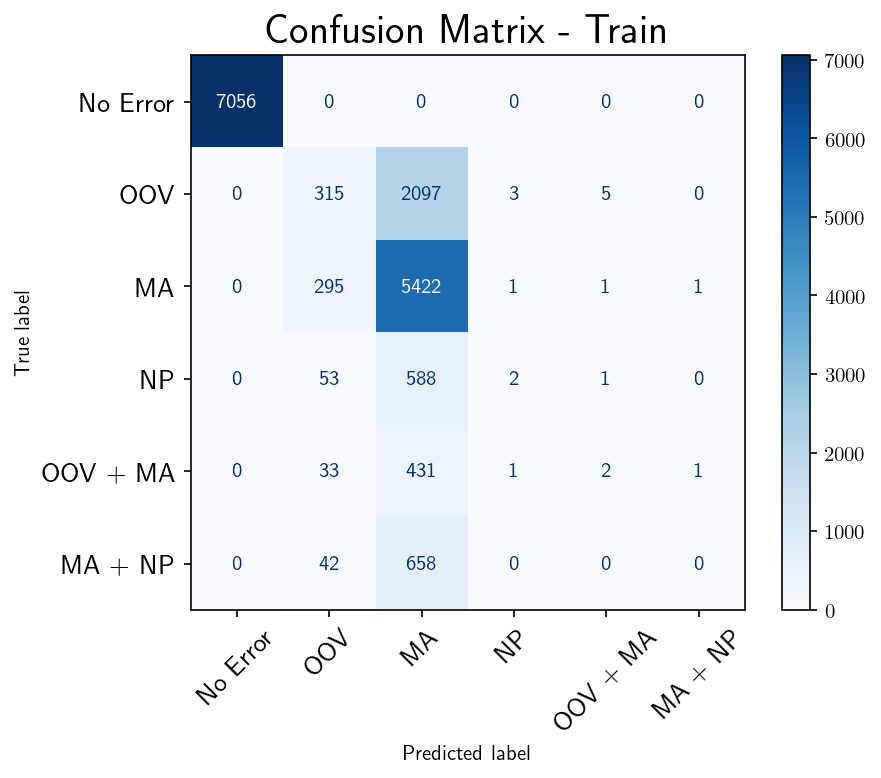

Confusion Matrix for Test:


<Figure size 2250x2250 with 0 Axes>

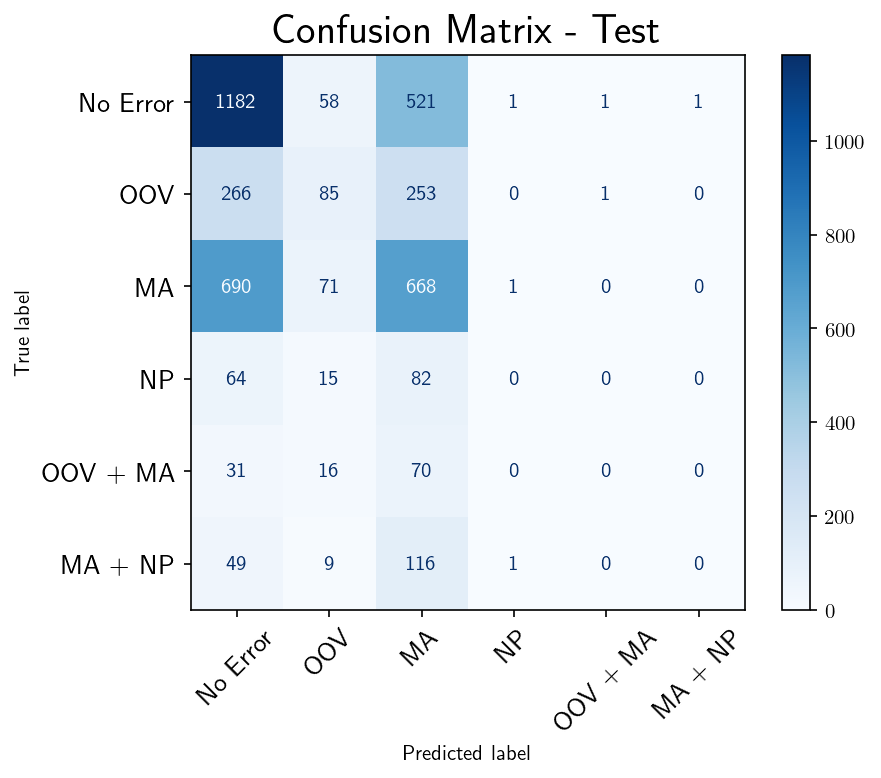

In [5]:
run_id = "4ee8c560f41a400f8a8c9e25b97f3cf6"
setting = 'LOSO'
outs = ['1out', '2Out', '3out', '4out', '5out']

LOSO_f1_train, LOSO_f1_test, LOSO_f1_train_specific, LOSO_f1_test_specific, LOSO_f1_train_specific_weighted, LOSO_f1_test_specific_weighted, \
LOSO_acc_train, LOSO_acc_test, LOSO_acc_train_specific, LOSO_acc_test_specific,LOSO_jaccard_train, LOSO_jaccard_test,\
LOSO_jaccard_train_specific, LOSO_jaccard_test_specific, LOSO_jaccard_train_specific_weighted, LOSO_jaccard_test_specific_weighted, \
LOSO_cm_train, LOSO_cm_test, LOSO_cm_train_specific, LOSO_cm_test_specific, test_all_preds, test_all_preds_specific, test_all_probs, test_all_labels, \
test_all_labels_specific, test_all_gest_labels, test_all_subjects = retrieve_results_mlflow_sequential(outs=outs,
                                                                                    exp_kwargs=exp_kwargs,
                                                                                    setting=setting,
                                                                                    run_id=run_id)

samples_train = [3174,3476,3364,3382,3612]
samples_test = [1078,776,888,870,640]
train_times = [1, 1, 1, 1,1 ]
inference_rates = [0.001, 0.001, 0.001, 0.001, 0.001] #Example inference rates in seconds


#Compute only-error specific metrics
summary_df_specific = create_summary_df(LOSO_f1_train=LOSO_f1_train_specific, LOSO_f1_test=LOSO_f1_test_specific, LOSO_acc_train=LOSO_acc_train_specific,
                                    LOSO_acc_test=LOSO_acc_test_specific, LOSO_jaccard_train=LOSO_jaccard_train_specific, LOSO_jaccard_test=LOSO_jaccard_test_specific,
                                    samples_train=samples_train, samples_test=samples_test,inference_rates=inference_rates, train_times=train_times)

#Save binary summary df to csv
print("Error Specific Summary DataFrame:")
display(summary_df_specific)
summary_df_specific.to_csv(os.path.join(results_folder, 'LOSO_summary_df_binary.csv'), index=False)

#Compute error-specific cm
#plot_cm(LOSO_cm_train = LOSO_cm_train_specific, LOSO_cm_test= LOSO_cm_test_specific, image_folder=image_folder)

#Compute all error metrics
summary_df_all = create_summary_df(LOSO_f1_train=LOSO_f1_train, LOSO_f1_test=LOSO_f1_test, LOSO_acc_train=LOSO_acc_train,
                                    LOSO_acc_test=LOSO_acc_test, LOSO_jaccard_train=LOSO_jaccard_train, LOSO_jaccard_test=LOSO_jaccard_test,
                                    samples_train=samples_train, samples_test=samples_test,inference_rates=inference_rates, train_times=train_times)

#Save summary df to csv
print("Error Specific Summary DataFrame:")
display(summary_df_all)
summary_df_all.to_csv(os.path.join(results_folder, 'LOSO_summary_df.csv'), index=False)

print("Confusion Matrix for Train:")
plot_cm(LOSO_cm_train = LOSO_cm_train, LOSO_cm_test= LOSO_cm_test, image_folder=image_folder)